# Develop the integral of Gaussian distribution to compute the weight

We need the weighted average of the axial strain with given direction. To consider the weight on the triangular element with different sizes and distance from the seismic station, we numerically compute the integral of Gaussian distribution on the element.

2023.7.5 Kurama Okubo

In [1]:
import datetime
import os

import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import numpy as np
import pandas as pd
import h5py
import glob
import matplotlib as mpl
import seaborn as sns

import shutil
from tqdm import tqdm

import geopy.distance as gd # to compute distance from lat lon
from pyproj import Proj, Geod # used to compute the area of triangular element
from scipy import integrate

os.environ['TZ'] = 'GMT' # change time zone to avoid confusion in unix_tvec conversion

plt.rcParams["font.family"] = 'Arial'
# plt.rcParams["font.sans-serif"] = "DejaVu Sans, Arial, Helvetica, Lucida Grande, Verdana, Geneva, Lucid, Avant Garde, sans-serif"
plt.rcParams["font.size"] = 12
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["xtick.major.size"] = 4.75
plt.rcParams["xtick.major.width"] = 0.75
plt.rcParams["xtick.minor.size"] = 3
plt.rcParams["xtick.minor.width"] = 0.4
plt.rcParams["xtick.minor.visible"] = True

plt.rcParams["ytick.direction"] = "in"
plt.rcParams["ytick.major.size"] = 4.75
plt.rcParams["ytick.major.width"] = 0.75
plt.rcParams["ytick.minor.size"] = 3
plt.rcParams["ytick.minor.width"] = 0.4
plt.rcParams["ytick.minor.visible"] = True

plt.rcParams["savefig.transparent"] = True

plt.rcParams['axes.linewidth'] = 0.75


# Schematic of the integration

<img src="schematic_weighting_integral_gauss.png" alt="schematic" width="400"/>

Figure 1. Geometry of the seismic station and triangular element. The yellow triangle indicates the seismic station, where we locate the origin of coordinates.

Figure 1 shows the geometry of the triangular element and the location of seismic station. In this schematic, we integrate the two-dimensional Gaussian distribution on the triangular element. To conduct that, we need to formulate the location of $p$, which is in the element.

The formulation is followings:

$$\mathbf{a} = \mathbf{v}_1 - \mathbf{v}_0$$

$$\mathbf{b} = \mathbf{v}_2 - \mathbf{v}_0$$

$$\mathbf{p} = \mathbf{v}_0 + s\mathbf{a} + t\mathbf{b}$$

$$ s \ge 0, t \ge 0, ~  s+t \le 1, $$

$$w_i^k = \int_\Omega G(\mathbf{p}) dS $$

$$ = \int_0^1 \int_0^{1-s}  G(\mathbf{p}) \left| \dfrac{\partial (x, y)}{\partial (s, t)} \right| dt ds,$$

where the integration by substitution with

$$ x = v_{0x} + sa_x + tb_x, $$
$$ y = v_{0y} + sa_y + tb_y, $$

$$ \left| \dfrac{\partial (x, y)}{\partial (s, t)} \right| = a_x b_y - b_x a_y.$$

$$ G(\mathbf{p}) = \dfrac{1}{2 \pi \sigma^2}  \exp{\left(-\dfrac{|\mathbf{p}|^2}{2\sigma^2}\right)}.$$

Rewriting with $s$ and $t$,
$$ G(s, t) = \dfrac{1}{2 \pi \sigma^2}  \exp{\left(-\dfrac{|\mathbf{v}_0 + s\mathbf{a} + t\mathbf{b} |^2}{2\sigma^2}\right)}.$$

$w_i^k$ indicates the weight of $i$th element with $k$th seismic station. We can verify if $\sum_i w_i^k$ is unity by definision.

We compute the weight in the utm coordinate with shifting the coordinate such that the seismic staion locates at origin.

In [2]:
def f_Gaussian2D(t, s, a, b, v0, gauss_sig):
    """
    Return two-dimensional Gaussian distribution in the triangular element, G(s, t).
    Input:
    a, b, v0: vectors to v0 and along the edges of triangular element 
    sigma: standard deviation of Gaussian
    """
    p = np.linalg.norm(np.array(v0) + s * np.array(a) + t * np.array(b))
    J = np.abs(a[0]*b[1]-b[0]*a[1])
    return (1/(2*np.pi*gauss_sig**2)) * np.exp(-(p**2)/(2*gauss_sig**2)) * J

# 1. Synthetic test

We make triangular mesh on the cicle with the center as origin, and conduct the numerical integration of the Gaussian distribution.

Reference for the triangulation of circle: 
1. https://matplotlib.org/stable/gallery/images_contours_and_fields/triplot_demo.html
2. https://matplotlib.org/stable/gallery/images_contours_and_fields/tripcolor_demo.html

In [3]:
import matplotlib.tri as tri
# First create the x and y coordinates of the points.
origin_coord = [3,2]

n_angles = 18
n_radii = 12
radii = np.linspace(0, 10, n_radii)

angles = np.linspace(0, 2 * np.pi, n_angles, endpoint=False)
angles = np.repeat(angles[:, np.newaxis], n_radii, axis=1)
angles[:, 1::2] += np.pi / n_angles

x = (radii * np.cos(angles)).flatten() + origin_coord[0]
y = (radii * np.sin(angles)).flatten() + origin_coord[1]

triang = tri.Triangulation(x, y)

Text(0.5, 1.0, 'triplot of Delaunay triangulation')

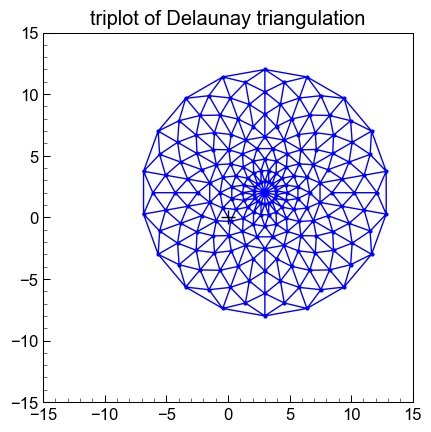

In [4]:
fig1, ax1 = plt.subplots()
ax1.set_aspect('equal')
ax1.triplot(triang, 'bo-', lw=1, ms=2)
ax1.plot(0, 0, '+k-', lw=1, ms=10)
ax1.set_xlim([-15, 15])
ax1.set_ylim([-15, 15])
ax1.set_title('triplot of Delaunay triangulation')

In [5]:
Ntri = len(triang.triangles)
gauss_sig = 2.5

weight = []
area = []

for triIDs in triang.triangles:
    i, j, k = triIDs

    v0 = np.array([triang.x[i] - origin_coord[0], triang.y[i] - origin_coord[1]])
    v1 = np.array([triang.x[j] - origin_coord[0], triang.y[j] - origin_coord[1]])
    v2 = np.array([triang.x[k] - origin_coord[0], triang.y[k] - origin_coord[1]])
    
    a = v1-v0
    b = v2-v0
    
    A = 0.5*np.abs(np.cross(a, b))
        
    w, err = integrate.dblquad(f_Gaussian2D, 0, 1, 0, lambda s: 1-s, args=(a, b, v0, gauss_sig),)

    assert err < 1e-12
    
    weight.append(w)
    area.append(A)

In [6]:
print(f"sum of weight: {np.sum(weight)} Area: {np.sum(area)}")
print(f"True area:{np.pi*radii.max()**2}")
Ntri

sum of weight: 0.9996047507882829 Area: 307.8181289931019
True area:314.1592653589793


378

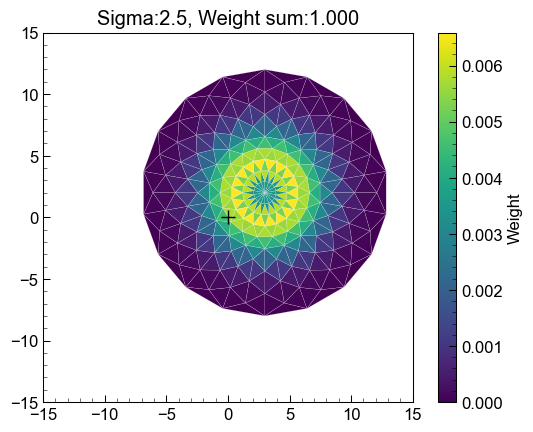

In [7]:
# plot with weighting colors
fig1, ax1 = plt.subplots()
ax1.set_aspect('equal')
# p1 = ax1.tripcolor(triang, weight, cmap="viridis", edgecolor="w", shading='flat')# vmin=0, vmax=0.01)
p1 = ax1.tripcolor(triang, weight, cmap="viridis", edgecolor="w", lw=0.1, shading='flat', vmin=0)# vmin=0, vmax=0.01)
ax1.plot(0, 0, '+k-', lw=1, ms=10)
ax1.set_xlim([-15, 15])
ax1.set_ylim([-15, 15])
ax1.set_title(f'Sigma:{gauss_sig:.1f}, Weight sum:{np.sum(weight):.3f}')
cbar = plt.colorbar(p1)
cbar.set_label(f'Weight')

The weight is larger around the center as the weights of element close to the center decreases due to the small area.

# 2. Test with GNSS coordinates

In [8]:
# Prepare the projection function from latlon to utm
UTMzone_BP = 10; 
proj_BP = Proj(proj='utm', zone=UTMzone_BP, ellps='WGS84')

In [9]:
# # Read strain
# df_deltastrain_all = pd.read_csv("./df_deltastrain_all.csv", index_col=False)


In [10]:
# # Select the snap shot at the reference snap
# ref_year = 2009
# ref_doy = 3 # some station has a lack of data on the beginning of 2009, so we start from doy=3 to obtain references of all the triangulars.
# df_refsnap = df_deltastrain_all[(df_deltastrain_all["year"]==ref_year) & (df_deltastrain_all["doy"]==ref_doy)].sort_values(by="triID")
# Ntri = len(df_refsnap)

In [11]:
# Dump the data frame to optimize the data size of csv to upload to github repository. You can reconstruct the refsnap.csv by loading "df_deltastrain_all.csv"
# df_refsnap.to_csv("df_deltastrain_refsnap.csv")

In [12]:
# Read the refsnap
df_refsnap = pd.read_csv("df_deltastrain_refsnap.csv", index_col=0)
Ntri = len(df_refsnap)

In [13]:
# Read BP network
df_BPstation = pd.read_csv("./BP_gmap-stations.txt", comment="#", header=None, sep="|")
df_BPstation = df_BPstation[[1, 3, 2]]
df_BPstation.columns = ["station", "lon", "lat"]
df_BPstation.head()

,station,lon,lat
0,CCRB,-120.55158,35.95718
1,EADB,-120.42262,35.89522
2,FROB,-120.48688,35.91095
3,GHIB,-120.34728,35.83225
4,JCNB,-120.43112,35.93897


In [14]:
Ntri

126

In [15]:
gauss_sig = 5.0 # extent of gaussian weight [km]
maxdist = 30.0 # exclude the stations outside of this distance [km]

df_gaussweight = pd.DataFrame(columns=["triID", "area", "dist", "weight", "weight_onlydist", "BPstation"])

for i, row in df_BPstation.iterrows():
    BP_stid = row.station
    # BP_stid = "EADB"
    df_st = df_BPstation[df_BPstation["station"]==BP_stid]
    # df_st.lon.values[0]
    for i in range(Ntri):
        snap_triid = i+1

        # get edges 
        df_snap_ref = df_refsnap.loc[df_refsnap["triID"]==snap_triid]
        lon1, lat1 = (df_snap_ref["lon1"].values[0], df_snap_ref["lat1"].values[0])
        lon2, lat2 = (df_snap_ref["lon2"].values[0], df_snap_ref["lat2"].values[0])
        lon3, lat3 = (df_snap_ref["lon3"].values[0], df_snap_ref["lat3"].values[0])
        mlon, mlat = (np.mean([lon1,lon2,lon3]), np.mean([lat1,lat2,lat3]))

        # compute distance between center of triangle and BP station
        coords1 = (mlat, mlon)
        coords2 = (df_st.lat.values[0], df_st.lon.values[0])
        dist_st = gd.geodesic(coords1, coords2).km # same unit with gauss_sig

        # UPDATE: compute integral of Gaussian on the triangular element
        #1. convert coordinates from latlon to utm
        st_x, st_y = proj_BP(df_st.lon.values[0], df_st.lat.values[0])
        x0, y0 = proj_BP(lon1, lat1) # the choice of v0 does not matter
        x1, y1 = proj_BP(lon2, lat2) # the choice of v0 does not matter
        x2, y2 = proj_BP(lon3, lat3) # the choice of v0 does not matter

        v0 = np.array([x0 - st_x, y0 - st_y])/1e3 #[m] -> [km]
        v1 = np.array([x1 - st_x, y1 - st_y])/1e3 #[m] -> [km]
        v2 = np.array([x2 - st_x, y2 - st_y])/1e3 #[m] -> [km]

        a = v1-v0
        b = v2-v0

        A = 0.5*np.abs(np.cross(a, b))/1e6 #[km^2]

        gaussweight, err = integrate.dblquad(f_Gaussian2D, 0, 1, 0, lambda s: 1-s, args=(a, b, v0, gauss_sig),)
#         print(err)
        assert err < 1e-8

        # For the debugging purpose, we compute the weight only with the distance
        if dist_st < maxdist:
            # compute gaussian weight
            gaussweight_onlydist = (1/(2*np.pi*gauss_sig**2)) * np.exp(-dist_st**2/(2*gauss_sig**2))
        else:
            gaussweight_onlydist = 0

        df_gaussweight = pd.concat([df_gaussweight, pd.DataFrame([[snap_triid, A, dist_st, gaussweight, gaussweight_onlydist, BP_stid]], columns=["triID", "area", "dist", "weight", "weight_onlydist", "BPstation"])])


In [16]:
for i, row in df_BPstation.iterrows():
    BP_stid = row.station
    w_sum = df_gaussweight[df_gaussweight["BPstation"]==BP_stid]["weight"].sum()
    print(f"{BP_stid} weight sum: {w_sum:.4f}")

CCRB weight sum: 1.0000
EADB weight sum: 1.0000
FROB weight sum: 1.0000
GHIB weight sum: 1.0000
JCNB weight sum: 1.0000
JCSB weight sum: 1.0000
LCCB weight sum: 1.0000
MMNB weight sum: 1.0000
RMNB weight sum: 1.0000
SCYB weight sum: 1.0000
SMNB weight sum: 1.0000
VARB weight sum: 1.0000
VCAB weight sum: 1.0000


# Plot Gaussian weight with the integral on the element

In [17]:
df_plotgaussian = pd.DataFrame(columns=["mlat", "mlon", "weight", "weight_onlydist", "BPstation"])

for i, raw in df_BPstation.iterrows():
    BP_stid = raw.station
    df_weight_st = df_gaussweight[df_gaussweight["BPstation"]==BP_stid]
    sum_weight = df_weight_st.weight.sum()

    assert np.abs(sum_weight - 1.0) < 1e-8 # check the sum of weight is unity
    
    # for debugging
    sum_weight_onlydist = df_weight_st.weight_onlydist.sum()

    for i in range(Ntri):
        snap_triid = i+1

        # get edges 
        df_snap_ref = df_refsnap.loc[df_refsnap["triID"]==snap_triid]
        lon1, lat1 = (df_snap_ref["lon1"].values[0], df_snap_ref["lat1"].values[0])
        lon2, lat2 = (df_snap_ref["lon2"].values[0], df_snap_ref["lat2"].values[0])
        lon3, lat3 = (df_snap_ref["lon3"].values[0], df_snap_ref["lat3"].values[0])
        mlon, mlat = (np.mean([lon1,lon2,lon3]), np.mean([lat1,lat2,lat3]))
        weight = df_weight_st[df_weight_st["triID"]==snap_triid].weight.values[0]
        weight_onlydist  = df_weight_st[df_weight_st["triID"]==snap_triid].weight_onlydist.values[0]/sum_weight_onlydist
        
        df_plotgaussian = pd.concat([df_plotgaussian, pd.DataFrame([[mlat, mlon, weight, weight_onlydist, BP_stid]], columns=["mlat", "mlon", "weight", "weight_onlydist", "BPstation"])])


In [18]:
cmap1 = sns.color_palette("viridis", as_cmap=True)
# manipulate colorpallet so than 0 is in gray
cmap1._lut[0:2] = np.array([ 1.0, 1.0,  1.0,  1.0])

In [ ]:
# Plot in space
f_lon_min = -120.65
f_lon_max = -120.3
f_lat_min = 35.775
f_lat_max = 36.1

approx_faultloc = [-120.6, 36.04, -120.35, 35.82] # selected with try and error

output_imgdir_weight = "./figure/spatial_gaussianweight"

if not os.path.exists(output_imgdir_weight):
    os.makedirs(output_imgdir_weight)
    
for i, raw in df_BPstation.iterrows():
# for i, raw in df_BPstation.iloc[1:2].iterrows():
    BP_stid = raw.station
    df_plotweight = df_plotgaussian[df_plotgaussian["BPstation"]==BP_stid]
    df_st = df_BPstation[df_BPstation["station"]==BP_stid]

    fig, ax = plt.subplots(1,1, figsize=(7, 6))

    ax.scatter(df_plotweight["mlon"], df_plotweight["mlat"], 40, c=df_plotweight["weight"], cmap=cmap1)
    ax.plot(df_st.lon, df_st.lat, "rv", ms=12)

    #---Plot triangular mesh---#
    for i, row in df_refsnap.iterrows():
        for meshedge in [[[row.lon1, row.lon2], [row.lat1, row.lat2]], [[row.lon2, row.lon3], [row.lat2, row.lat3]], [[row.lon3, row.lon1], [row.lat3, row.lat1]]]:
            ax.plot(meshedge[0], meshedge[1], "-", c="gray", lw=0.5, zorder=-10)
    
    #---Plot approximated fault loc---#
    ax.plot([approx_faultloc[0], approx_faultloc[2]], [approx_faultloc[1], approx_faultloc[3]], 
            'bo', ls="--", lw=1.0, zorder=-2)

    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

    ax.set_xlim([f_lon_min, f_lon_max])
    ax.set_ylim([f_lat_min, f_lat_max])

    #---Plot scale---#
    scale_loc1 = [35.80, -120.40]
    scale_loc2 = [35.80, -120.34468] # found by try and error
    scale_dist_st = gd.geodesic([35.80, 120.40], [35.80, 120.34468]).km
#     print(f"scale length:{scale_dist_st}km")
    ax.plot([scale_loc1[1], scale_loc2[1]], [scale_loc1[0], scale_loc2[0]],'k-', lw=1.0, zorder=-2)
    ax.text((scale_loc1[1]+scale_loc2[1])/2, scale_loc1[0]-0.01, f"{scale_dist_st:.1f}km", ha="center")
    
    # color bar
    normalize = mpl.colors.Normalize(vmin=0, vmax=0.3)
    cbar=fig.colorbar(mpl.cm.ScalarMappable(norm=normalize, cmap=cmap1),
                     orientation='vertical', ax=ax, location = 'right',
                     label="Weight")

    # ax.axis('equal')

    ax.set_title(f"Weight of {BP_stid}")

    plt.tight_layout()
    foname = output_imgdir_weight+f"/debug_spatialweight_{BP_stid}.png"
    plt.savefig(foname, dpi=300)
    
    foname = output_imgdir_weight+f"/debug_spatialweight_{BP_stid}.eps"
    plt.savefig(foname, dpi=300)
#     if i==len(df_BPstation)-1:
#         break
        
#     plt.clf()
#     plt.close()

## Plot the weight only with distance for debugging

We plot the weight using only the distance from station to element:

$$ G(r) = \dfrac{1}{2 \pi \sigma^2} \exp{ \left( -\dfrac{r^2}{2 \sigma^2}\right)}, $$

for the sake of comparison to the weight with the integration of Gaussian.

In [ ]:
# Plot in space
f_lon_min = -120.65
f_lon_max = -120.3
f_lat_min = 35.775
f_lat_max = 36.1

approx_faultloc = [-120.6, 36.04, -120.35, 35.82] # selected with try and error

output_imgdir_weight = "./figure/debug_spatial_gaussianweight_onlydist"

if not os.path.exists(output_imgdir_weight):
    os.makedirs(output_imgdir_weight)
    
for i, raw in df_BPstation.iterrows():
# for i, raw in df_BPstation.iloc[1:2].iterrows():
    BP_stid = raw.station
    df_plotweight = df_plotgaussian[df_plotgaussian["BPstation"]==BP_stid]
    df_st = df_BPstation[df_BPstation["station"]==BP_stid]

    fig, ax = plt.subplots(1,1, figsize=(7, 6))

    ax.scatter(df_plotweight["mlon"], df_plotweight["mlat"], 40, c=df_plotweight["weight_onlydist"], cmap=cmap1)
    ax.plot(df_st.lon, df_st.lat, "rv", ms=12)

    #---Plot triangular mesh---#
    for i, row in df_refsnap.iterrows():
        for meshedge in [[[row.lon1, row.lon2], [row.lat1, row.lat2]], [[row.lon2, row.lon3], [row.lat2, row.lat3]], [[row.lon3, row.lon1], [row.lat3, row.lat1]]]:
            ax.plot(meshedge[0], meshedge[1], "-", c="gray", lw=0.5, zorder=-10)
    
    #---Plot approximated fault loc---#
    ax.plot([approx_faultloc[0], approx_faultloc[2]], [approx_faultloc[1], approx_faultloc[3]], 
            'bo', ls="--", lw=1.0, zorder=-2)

    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

    ax.set_xlim([f_lon_min, f_lon_max])
    ax.set_ylim([f_lat_min, f_lat_max])

    #---Plot scale---#
    scale_loc1 = [35.80, -120.40]
    scale_loc2 = [35.80, -120.34468] # found by try and error
    scale_dist_st = gd.geodesic([35.80, 120.40], [35.80, 120.34468]).km
#     print(f"scale length:{scale_dist_st}km")
    ax.plot([scale_loc1[1], scale_loc2[1]], [scale_loc1[0], scale_loc2[0]],'k-', lw=1.0, zorder=-2)
    ax.text((scale_loc1[1]+scale_loc2[1])/2, scale_loc1[0]-0.01, f"{scale_dist_st:.1f}km", ha="center")
    
    # color bar
    normalize = mpl.colors.Normalize(vmin=0, vmax=0.3)
    cbar=fig.colorbar(mpl.cm.ScalarMappable(norm=normalize, cmap=cmap1),
                     orientation='vertical', ax=ax, location = 'right',
                     label="Weight")

    # ax.axis('equal')

    ax.set_title(f"Weight of {BP_stid}")

    plt.tight_layout()
    foname = output_imgdir_weight+f"/debug_spatialweight_{BP_stid}_onlydist.png"
    plt.savefig(foname, dpi=300)
    
#     if i==len(df_BPstation)-1:
#         break
        
#     plt.clf()
#     plt.close()

# Summary

We computed the weight with the numerical integration of Gaussian. We use this to evaluate the time series of cumulative strain.